<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Datos del alumno:

- Alumno: Víctor David Silva
- Cohorte: 14
- Corpus: letras de los discos de Linkin Park.

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [39]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import softmax


In [40]:
import tensorflow as tf

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0


### Datos
Como ejemplo se utilizará como corpus un dataset canciones de bandas de habla inglés.

In [41]:
# Leer el archivo de texto completo
with open('ALL_LP_lyrics.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Dividir el texto en oraciones utilizando el punto como separador
sentences = text.split('\n')

# Crear un DataFrame a partir de la lista de oraciones
df = pd.DataFrame(sentences, columns=['Sentence'])

# Mostrar las primeras filas del DataFrame
print(df.head())

                              Sentence
0                             Papercut
1              [Verse 1: Mike Shinoda]
2   Why does it feel like night today?
3  Something in here's not right today
4           Why am I so uptight today?


In [42]:
'''
n = 7500  # Cambia este número según cuántas filas quieras seleccionar
df_sample = df.head(n)

start_row = 0   # Índice de la fila inicial
end_row = 7500  # Índice de la fila final (exclusivo)

df = df.iloc[start_row:end_row]
'''

'\nn = 7500  # Cambia este número según cuántas filas quieras seleccionar\ndf_sample = df.head(n)\n\nstart_row = 0   # Índice de la fila inicial\nend_row = 7500  # Índice de la fila final (exclusivo)\n\ndf = df.iloc[start_row:end_row]\n'

Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [43]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 5384


### Elegir el tamaño del contexto

In [44]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding, para rellenar secuencias a un tamaño máximo, todo el tensor queda definido y se puede pasar a la gpu 


In [45]:
# cada verso lo guardamos en una lista
#text = list(df.loc[:,0])
#text

# Cada verso lo guardamos en una lista
text = list(df['Sentence'])
#print(text)

In [46]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [47]:
text[4]

'Why am I so uptight today?'

In [48]:
segmented_sentences[4]

['why', 'am', 'i', 'so', 'uptight', 'today']

In [49]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([4.241e+03, 1.128e+03, 1.100e+01, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.,   9.,  18.,  27.,  36.,  45.,  54.,  63.,  72.,  81.,  90.,
         99., 108., 117., 126., 135., 144., 153., 162., 171., 180.]),
 <BarContainer object of 20 artists>)

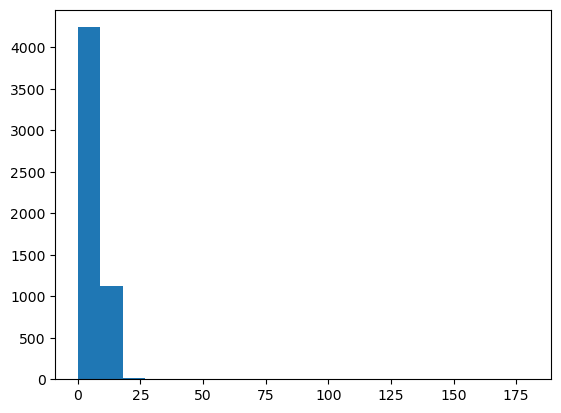

In [50]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [51]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 9


###  Tokenizar

In [52]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [53]:
tokenized_sentences[0]

[1369]

In [54]:
segmented_sentences[0]

['papercut']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [55]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

\Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

Por ejemplo, si tenemos el texto *La bella y graciosa moza marchóse a lavar la ropa* y nuestro contexto es de 5 palabras, tendremos:

- *La bella y graciosa moza*
- *bella y graciosa moza marchóse*
- *y graciosa moza marchóse a*
- *graciosa moza marchóse a lavar*
- *moza marchóse a lavar la*
- *marchóse a lavar la ropa*

In [56]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [57]:
len(tok_sent)

5223

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [58]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo, el +1 es porque es many to many y se porque vamos a predecir un valor
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [59]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [60]:
train_seqs.shape
#Quedan 10737 textos de tamaño 21

(27323, 10)

In [61]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [62]:
y.shape

(27323, 9)

In [63]:
# Palabras del vocabulario
tok.index_word
# La capa final va a ser una softmax Cuando hagamos una predicción. 

{1: 'the',
 2: 'i',
 3: 'you',
 4: 'to',
 5: 'and',
 6: 'me',
 7: 'of',
 8: 'in',
 9: 'chorus',
 10: 'it',
 11: 'chester',
 12: 'bennington',
 13: 'my',
 14: 'a',
 15: 'all',
 16: 'be',
 17: "i'm",
 18: 'that',
 19: 'your',
 20: 'mike',
 21: 'shinoda',
 22: 'what',
 23: 'oh',
 24: 'so',
 25: 'is',
 26: 'verse',
 27: "don't",
 28: 'away',
 29: 'on',
 30: 'but',
 31: 'for',
 32: 'no',
 33: 'this',
 34: 'back',
 35: 'like',
 36: "it's",
 37: 'up',
 38: 'down',
 39: 'now',
 40: 'ah',
 41: 'know',
 42: 'with',
 43: "can't",
 44: 'let',
 45: 'wanna',
 46: 'just',
 47: 'when',
 48: 'say',
 49: 'out',
 50: 'one',
 51: 'go',
 52: 'we',
 53: "you're",
 54: 'not',
 55: "i've",
 56: 'never',
 57: 'na',
 58: 'myself',
 59: 'pre',
 60: '1',
 61: '2',
 62: 'from',
 63: 'take',
 64: 'see',
 65: 'was',
 66: 'time',
 67: 'give',
 68: 'inside',
 69: 'got',
 70: 'have',
 71: 'can',
 72: 'will',
 73: "you've",
 74: 'more',
 75: 'come',
 76: 'do',
 77: 'right',
 78: 'they',
 79: 'if',
 80: 'how',
 81: 'want

In [64]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2376

In [65]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)
# Se reserva el token 0 para lo que no conoce

{'the': 1, 'i': 2, 'you': 3, 'to': 4, 'and': 5, 'me': 6, 'of': 7, 'in': 8, 'chorus': 9, 'it': 10, 'chester': 11, 'bennington': 12, 'my': 13, 'a': 14, 'all': 15, 'be': 16, "i'm": 17, 'that': 18, 'your': 19, 'mike': 20, 'shinoda': 21, 'what': 22, 'oh': 23, 'so': 24, 'is': 25, 'verse': 26, "don't": 27, 'away': 28, 'on': 29, 'but': 30, 'for': 31, 'no': 32, 'this': 33, 'back': 34, 'like': 35, "it's": 36, 'up': 37, 'down': 38, 'now': 39, 'ah': 40, 'know': 41, 'with': 42, "can't": 43, 'let': 44, 'wanna': 45, 'just': 46, 'when': 47, 'say': 48, 'out': 49, 'one': 50, 'go': 51, 'we': 52, "you're": 53, 'not': 54, "i've": 55, 'never': 56, 'na': 57, 'myself': 58, 'pre': 59, '1': 60, '2': 61, 'from': 62, 'take': 63, 'see': 64, 'was': 65, 'time': 66, 'give': 67, 'inside': 68, 'got': 69, 'have': 70, 'can': 71, 'will': 72, "you've": 73, 'more': 74, 'come': 75, 'do': 76, 'right': 77, 'they': 78, 'if': 79, 'how': 80, 'want': 81, 'at': 82, "'cause": 83, 'way': 84, 'there': 85, 'fall': 86, "i'll": 87, 'get'

In [66]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'papercut': 1, 'mike': 237, '1': 94, 'verse': 198, 'shinoda': 236, 'night': 13, 'like': 164, 'why': 46, 'does': 3, 'it': 309, 'feel': 65, 'today': 27, 'not': 110, 'something': 31, 'in': 373, "here's": 2, 'right': 69, 'am': 22, 'i': 998, 'uptight': 1, 'so': 209, 'got': 82, "paranoia's": 2, 'all': 275, 'left': 37, 'what': 210, 'first': 4, "don't": 177, 'stressed': 1, 'me': 419, 'know': 131, 'was': 89, 'how': 70, 'the': 1012, 'or': 31, 'fed': 1, 'pressure': 5, 'but': 180, 'feels': 8, 'just': 123, 'a': 284, 'voice': 10, 'head': 23, 'back': 164, 'have': 79, 'to': 747, 'my': 301, 'of': 367, 'pre': 95, 'chorus': 364, 'that': 244, 'hold': 26, 'inside': 83, 'face': 46, 'eyes': 28, 'when': 125, 'close': 15, 'awakes': 2, 'watches': 4, 'every': 58, 'time': 85, 'lie': 22, 'laughs': 2, 'fall': 65, 'and': 526, 'everything': 60, 'swim': 3, 'sink': 2, "it's": 159, 'here': 31, 'is': 193, 'skin': 28, 'underneath': 2, 'chester': 322, 'bennington': 322, 'over': 18, 'paranoid': 6


### Definir el modelo base

In [67]:
# Hay que probar cambiando las capas
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar. Se le puede dar un embedding ya entrenado. 
# input_shape: está en None pero podríamos poner 20, entran 20 tokens.
# output_dim: es el tamaño del embedding
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

# Esta capa recibe una secuencia de vectores
model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

# Se stakean 2 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(LSTM(100, return_sequences=True)) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
# +1 debido a palabras nuevas que pudo no haber aprendido
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE,
# que en ese caso sería solo CategoricalCrossentropy().
# En el fondo es un problema de clasificación.
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
#model.compile(
#    loss=SparseCategoricalCrossentropy(),
#    optimizer=Adam(),  # Cambia 'rmsprop' por Adam
#    metrics=['accuracy']  # Puedes agregar métricas adicionales si es necesario
#)
model.summary()

# La salida es del tamaño del vocabulario

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 50)          118850    
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         60400     
                                                                 
 lstm_3 (LSTM)               (None, None, 100)         80400     
                                                                 
 dense_3 (Dense)             (None, None, 2377)        240077    
                                                                 
Total params: 499727 (1.91 MB)
Trainable params: 499727 (1.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [68]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)

    #Se va a ejecutar cuando termine una época, calculando la perplejidad y si emperora lo interrumpe
    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [69]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)
# Hay que seleccionar un Corpus más sustancioso para entrenar el modelo de lenguaje.

Epoch 1/20


2024-08-07 21:41:44.949121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 21:41:45.254532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 21:41:45.360461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 21:41:45.532915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 21:41:45.709497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


427/427 [==============================] - ETA: 0s - loss: 3.9669

2024-08-07 21:42:00.118831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 21:42:00.206435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 21:42:00.298737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



 mean perplexity: 1257553.257351262 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 21s 45ms/step - loss: 3.9669
Epoch 2/20
427/427 [==============================] - ETA: 0s - loss: 3.1526
 mean perplexity: 10460.165382113857 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 16s 38ms/step - loss: 3.1526
Epoch 3/20
427/427 [==============================] - ETA: 0s - loss: 2.9693
 mean perplexity: 4196.546832046285 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 16s 38ms/step - loss: 2.9693
Epoch 4/20
427/427 [==============================] - ETA: 0s - loss: 2.8500
 mean perplexity: 5430.557436993683 

427/427 [==============================] - 14s 32ms/step - loss: 2.8500
Epoch 5/20
426/427 [============================>.] - ETA: 0s - loss: 2.7440
 mean perplexity: 6085.481335557496 

427/427 [==============================] - 13s 30ms/step - loss: 2.7440
Epoch 6/20
427/427 [==============================] - ETA: 0s - loss: 2.6508
 mean perplexity: 9224.44368888164 

427/427 [==============================] - 13s 29ms/step - loss: 2.6508
Epoch 7/20
427/427 [==============================] - ETA: 0s - loss: 2.5629
 mean perplexity: 9511.06053591834 

427/427 [==============================] - 12s 29ms/step - loss: 2.5629
Epoch 8/20
427/427 [==============================] - ETA: 0s - loss: 2.4792
 mean perplexity: 13560.171425242454 

Stopping training...
427/427 [===================

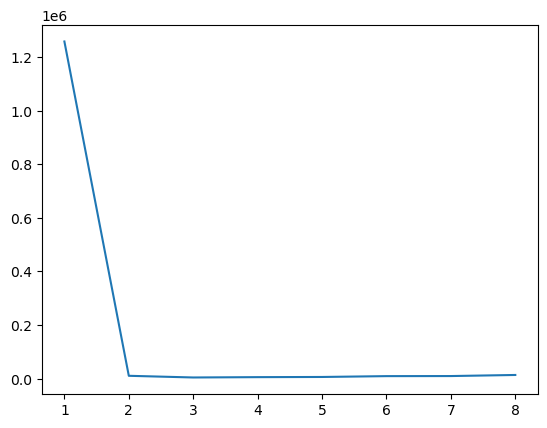

In [70]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [71]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model')


#### Predicción de próxima palabra

In [72]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [36]:
# Librería que permite hacer interfaces para probar modelos
import gradio as gr

def model_response(human_text):

    # Encodeamos, tokeniza el texto de entrada
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo, lo paddea
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax, pedimos el argumento máximo porque es greedy
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


2024-07-25 12:30:09.036820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-25 12:30:09.130227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-25 12:30:09.193911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 455ms/step
Keyboard interruption in main thread... closing server.


#### Generación de secuencias

In [73]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [74]:
input_text='I wanna run away and open up my'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=1)

2024-08-07 21:43:44.950765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 21:43:45.055982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 21:43:45.147012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 496ms/step


'I wanna run away and open up my act'

####  Beam search y muestreo aleatorio

In [75]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [76]:
# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [77]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=2,input="I wanna run away and open up",temp=1,mode='sto') #mode=sto es estocásitco, son muestreos aleatorios, pero puede ser determinista

2024-08-07 21:43:45.547518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 21:43:45.638495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 21:43:45.716092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [78]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 11)

In [79]:
# veamos las salidas
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

['i wanna run away and open up the little']
['i wanna run away and open up the mind']
['i wanna run away and open up me push']
['i wanna run away and open up the other']
['i wanna run away and open up the walked']
['i wanna run away and open up me open']
['i wanna run away and open up the certain']
['i wanna run away and open up the mine']
['i wanna run away and open up me hear']
['i wanna run away and open up me up']


Se ve que el modelo 0 tiene una predicción pobre, no acertando en el generador de secuencias ni con beam search. Se necesitan más documentos y la arquitectura es muy sencilla.

### Modelo 1 - SimpleRNN (3 capas de dim=250, Embedding dim=100) 

In [80]:
# Hay que probar cambiando las capas
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar. Se le puede dar un embedding ya entrenado. 
# input_shape: está en None pero podríamos poner 20, entran 20 tokens.
# output_dim: es el tamaño del embedding
model.add(Embedding(input_dim=vocab_size+1, output_dim=100, input_shape=(None,)))

# Esta capa recibe una secuencia de vectores
model.add(SimpleRNN(250, return_sequences=True))
# model.add(Dropout(0.2))

# Se stakean 2 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(SimpleRNN(250, return_sequences=True)) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))

# Se stakean 3 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(SimpleRNN(250, return_sequences=True)) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
# +1 debido a palabras nuevas que pudo no haber aprendido
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE,
# que en ese caso sería solo CategoricalCrossentropy().
# En el fondo es un problema de clasificación.
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
#model.compile(
#    loss=SparseCategoricalCrossentropy(),
#    optimizer=Adam(),  # Cambia 'rmsprop' por Adam
#    metrics=['accuracy']  # Puedes agregar métricas adicionales si es necesario
#)
model.summary()

# La salida es del tamaño del vocabulario

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         237700    
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, None, 250)         87750     
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, None, 250)         125250    
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, None, 250)         125250    
                                                                 
 dense_4 (Dense)             (None, None, 2377)        596627    
                                                                 
Total params: 1172577 (4.47 MB)
Trainable params: 1172577 (4.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)
# Hay que seleccionar un Corpus más sustancioso para entrenar el modelo de lenguaje.

Epoch 1/20


2024-08-07 21:43:47.106098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


427/427 [==============================] - ETA: 0s - loss: 3.3335

2024-08-07 21:45:00.534227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



 mean perplexity: 2990.3828074319217 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 81s 185ms/step - loss: 3.3335
Epoch 2/20
427/427 [==============================] - ETA: 0s - loss: 2.7747
 mean perplexity: 1824.109259199945 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 80s 187ms/step - loss: 2.7747
Epoch 3/20
427/427 [==============================] - ETA: 0s - loss: 2.4354
 mean perplexity: 2133.2115898014686 

427/427 [==============================] - 81s 189ms/step - loss: 2.4354
Epoch 4/20
427/427 [==============================] - ETA: 0s - loss: 2.1514
 mean perplexity: 2751.16229350742 

427/427 [==============================] - 81s 190ms/step - loss: 2.1514
Epoch 5/20
427/427 [==============================] - ETA: 0s - loss: 1.9106
 mean perplexity: 2822.6898358050857 

427/427 [==============================] - 82s 191ms/step - loss: 1.9106
Epoch 6/20
427/427 [==============================] - ETA: 0s - loss: 1.7273
 mean perplexity: 2426.5717176560256 

427/427 [==============================] - 83s 194ms/step - loss: 1.7273
Epoch 7/20
427/427 [==============================] - ETA: 0s - loss: 1.5888
 mean perplexity: 3258.534908440407 

Stopping training...
427/427 [===========

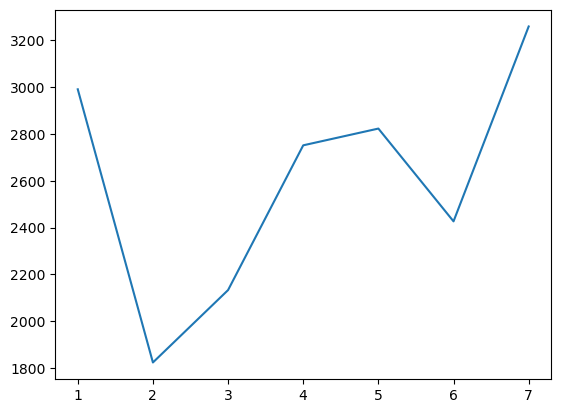

In [82]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [83]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_1 = keras.models.load_model('my_model')

#### Generación de secuencias

In [84]:
input_text='I wanna run away and open up my'

generate_seq(model_1, tok, input_text, max_length=max_context_size, n_words=1)

2024-08-07 21:53:16.937381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 838ms/step


'I wanna run away and open up my act'

####  Beam search y muestreo aleatorio

In [85]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model_1,num_beams=5,num_words=2,input="I wanna run away and open up",temp=1,mode='sto') #mode=sto es estocásitco, son muestreos aleatorios, pero puede ser determinista

2024-08-07 21:53:17.890922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [86]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(5, 11)

In [87]:
# veamos las salidas
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

['i wanna run away and open up to always']
['i wanna run away and open up in the']
['i wanna run away and open up in the']
['i wanna run away and open up to so']
['i wanna run away and open up to make']


Se ve que el modelo 1 tiene una mala predicción, no acertando en el generador de secuencias ni con beam search, aunque la perplexity y el train loss son menores. Se necesitan más documentos y la arquitectura es muy sencilla.

### Modelo 2 - SimpleRNN Bidirectional (4 capas de dim=250, Embedding dim=100)

In [88]:
# Hay que probar cambiando las capas
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar. Se le puede dar un embedding ya entrenado. 
# input_shape: está en None pero podríamos poner 20, entran 20 tokens.
# output_dim: es el tamaño del embedding
model.add(Embedding(input_dim=vocab_size+1, output_dim=100, input_shape=(None,)))

# Esta capa recibe una secuencia de vectores
model.add(Bidirectional(SimpleRNN(250, return_sequences=True)))
# model.add(Dropout(0.2))

# Se stakean 2 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(Bidirectional(SimpleRNN(250, return_sequences=True))) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))

# Se stakean 3 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(Bidirectional(SimpleRNN(250, return_sequences=True))) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))

# Se stakean 4 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(Bidirectional(SimpleRNN(250, return_sequences=True))) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
# +1 debido a palabras nuevas que pudo no haber aprendido
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE,
# que en ese caso sería solo CategoricalCrossentropy().
# En el fondo es un problema de clasificación.
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
#model.compile(
#    loss=SparseCategoricalCrossentropy(),
#    optimizer=Adam(),  # Cambia 'rmsprop' por Adam
#    metrics=['accuracy']  # Puedes agregar métricas adicionales si es necesario
#)
model.summary()

# La salida es del tamaño del vocabulario

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 100)         237700    
                                                                 
 bidirectional_4 (Bidirecti  (None, None, 500)         175500    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, None, 500)         375500    
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, None, 500)         375500    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, None, 500)         375500    
 onal)                                                

In [89]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)
# Hay que seleccionar un Corpus más sustancioso para entrenar el modelo de lenguaje.

Epoch 1/20


2024-08-07 21:53:19.909185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


427/427 [==============================] - ETA: 0s - loss: 1.7745

2024-08-07 21:56:51.265096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



 mean perplexity: 921.1366208837464 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 231s 532ms/step - loss: 1.7745
Epoch 2/20
427/427 [==============================] - ETA: 0s - loss: 0.5304
 mean perplexity: 930.7467363751607 

427/427 [==============================] - 221s 518ms/step - loss: 0.5304
Epoch 3/20
427/427 [==============================] - ETA: 0s - loss: 0.3844
 mean perplexity: 851.8733295925156 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 227s 531ms/step - loss: 0.3844
Epoch 4/20
427/427 [==============================] - ETA: 0s - loss: 0.3172
 mean perplexity: 1091.234976630378 

427/427 [==============================] - 218s 510ms/step - loss: 0.3172
Epoch 5/20
427/427 [==============================] - ETA: 0s - loss: 0.2748
 mean perplexity: 1221.3786539994903 

427/427 [==============================] - 242s 566ms/step - loss: 0.2748
Epoch 6/20
427/427 [==============================] - ETA: 0s - loss: 0.2426
 mean perplexity: 1120.1744504714436 

427/427 [==============================] - 243s 569ms/step - loss: 0.2426
Epoch 7/20
427/427 [==============================] - ETA: 0s - loss: 0.2194
 mean perplexity: 1399.9280489693726 

427/427 [==============================] - 231s 541ms/step - loss: 0.2194
Epoch 8/20
427/427 [==============================] - ETA: 0s - loss: 0.2009
 mean perplexity: 2231.86375651867 

Stopping training...
427/427 [======

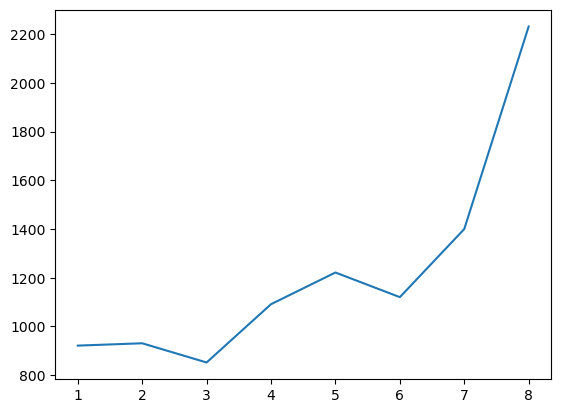

In [90]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [91]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_2 = keras.models.load_model('my_model')

#### Generación de secuencias

In [92]:
input_text='I wanna run away and open up my'

generate_seq(model_2, tok, input_text, max_length=max_context_size, n_words=1)

2024-08-07 22:25:32.578815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 897ms/step


'I wanna run away and open up my mind'

####  Beam search y muestreo aleatorio

In [93]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model_2,num_beams=5,num_words=2,input="I wanna run away and open up",temp=1,mode='sto') #mode=sto es estocásitco, son muestreos aleatorios, pero puede ser determinista

2024-08-07 22:25:33.593334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [94]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(5, 11)

In [95]:
# veamos las salidas
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

['i wanna run away and open up my mind']
['i wanna run away and open up my mind']
['i wanna run away and open up my mind']
['i wanna run away and open up my mind']
['i wanna run away and open up my mind']


Se ve que el modelo 2 tiene una mejor predicción , acertando en el generador de secuencias y con beam search, aunque todos den igual con este último. Se necesitan más documentos para mejorar su desempeño.

### Modelo 3 - LSTM (4 capas de dim=150, Embedding dim=50)

In [96]:
# Hay que probar cambiando las capas
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar. Se le puede dar un embedding ya entrenado. 
# input_shape: está en None pero podríamos poner 20, entran 20 tokens.
# output_dim: es el tamaño del embedding
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

# Esta capa recibe una secuencia de vectores
model.add(LSTM(150, return_sequences=True))
# model.add(Dropout(0.2))

# Se stakean 2 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(LSTM(150, return_sequences=True)) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))

# Se stakean 3 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(LSTM(150, return_sequences=True)) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))

# Se stakean 4 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(LSTM(150, return_sequences=True)) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
# +1 debido a palabras nuevas que pudo no haber aprendido
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE,
# que en ese caso sería solo CategoricalCrossentropy().
# En el fondo es un problema de clasificación.
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
#model.compile(
#    loss=SparseCategoricalCrossentropy(),
#    optimizer=Adam(),  # Cambia 'rmsprop' por Adam
#    metrics=['accuracy']  # Puedes agregar métricas adicionales si es necesario
#)
model.summary()

# La salida es del tamaño del vocabulario

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 50)          118850    
                                                                 
 lstm_4 (LSTM)               (None, None, 150)         120600    
                                                                 
 lstm_5 (LSTM)               (None, None, 150)         180600    
                                                                 
 lstm_6 (LSTM)               (None, None, 150)         180600    
                                                                 
 lstm_7 (LSTM)               (None, None, 150)         180600    
                                                                 
 dense_6 (Dense)             (None, None, 2377)        358927    
                                                                 
Total params: 1140177 (4.35 MB)
Trainable params: 1140

In [97]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)
# Hay que seleccionar un Corpus más sustancioso para entrenar el modelo de lenguaje.

Epoch 1/20


2024-08-07 22:25:38.081918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:25:38.886341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:25:39.086876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:25:39.234989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:25:39.389754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:25:39.734950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:25:40.064902: I tensorflow/core/grappler/optimizers/cust

427/427 [==============================] - ETA: 0s - loss: 3.6517

2024-08-07 22:26:12.316168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:26:12.566114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:26:12.774958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:26:12.915799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:26:13.126246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



 mean perplexity: 31158.721450984805 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 48s 99ms/step - loss: 3.6517
Epoch 2/20
427/427 [==============================] - ETA: 0s - loss: 3.0646
 mean perplexity: 5012.17692400513 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 35s 83ms/step - loss: 3.0646
Epoch 3/20
427/427 [==============================] - ETA: 0s - loss: 2.8693
 mean perplexity: 7147.860672038365 

427/427 [==============================] - 28s 66ms/step - loss: 2.8693
Epoch 4/20
427/427 [==============================] - ETA: 0s - loss: 2.7350
 mean perplexity: 6903.739472035905 

427/427 [==============================] - 28s 65ms/step - loss: 2.7350
Epoch 5/20
427/427 [==============================] - ETA: 0s - loss: 2.6281
 mean perplexity: 8283.309135162188 

427/427 [==============================] - 27s 64ms/step - loss: 2.6281
Epoch 6/20
427/427 [==============================] - ETA: 0s - loss: 2.5359
 mean perplexity: 10389.180417377713 

427/427 [==============================] - 28s 64ms/step - loss: 2.5359
Epoch 7/20
427/427 [==============================] - ETA: 0s - loss: 2.4595
 mean perplexity: 9841.16256409517 

Stopping training...
427/427 [==================

Epoch 8, mean perplexity: 21347.916345877944,  loss: 2.7063, 4 capas de 50 con 32 de batch y 50 de embedding
epoch 9 mean perplexity: 19704.428007955492, loss: 2.3276, 4 cpas de 150 con 32 de batch y 50 de embedding

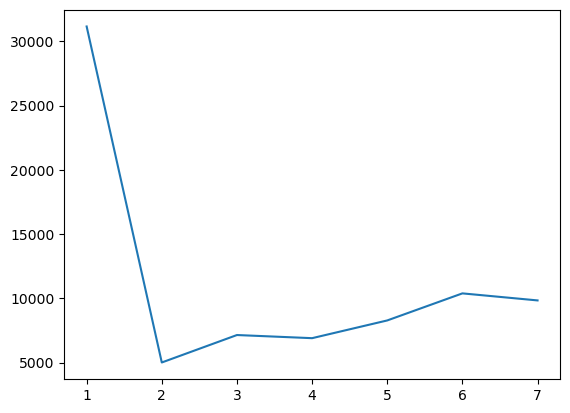

In [98]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [99]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_3 = keras.models.load_model('my_model')

#### Generación de secuencias

In [100]:
input_text='I wanna run away and open up my'

generate_seq(model_3, tok, input_text, max_length=max_context_size, n_words=1)

2024-08-07 22:29:22.583678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:22.827987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:23.005443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:23.187003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:23.368206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


'I wanna run away and open up my act'

####  Beam search y muestreo aleatorio

In [101]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model_3,num_beams=5,num_words=2,input="I wanna run away and open up",temp=1,mode='sto') #mode=sto es estocásitco, son muestreos aleatorios, pero puede ser determinista

2024-08-07 22:29:24.210741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:24.446374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:24.630246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:24.804124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:24.987071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [102]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(5, 11)

In [103]:
# veamos las salidas
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

['i wanna run away and open up have like']
['i wanna run away and open up inside a']
['i wanna run away and open up inside you']
['i wanna run away and open up inside around']
['i wanna run away and open up down it']


Se ve que el modelo 3 tiene una mala predicción, no acertando en el generador de secuencias ni con beam search, es similar en desempeño al modelo 1. Se necesitan más documentos.

### Modelo 4 - LSTM Bidirectional(Embedding dim=100, 4 capas LSTM de dim=150, Dropout=0.2)

In [104]:
# Hay que probar cambiando las capas
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar. Se le puede dar un embedding ya entrenado. 
# input_shape: está en None pero podríamos poner 20, entran 20 tokens.
# output_dim: es el tamaño del embedding
model.add(Embedding(input_dim=vocab_size+1, output_dim=100, input_shape=(None,)))

# Esta capa recibe una secuencia de vectores
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))

# Se stakean 2 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(Bidirectional(LSTM(150, return_sequences=True))) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Se stakean 3 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(Bidirectional(LSTM(150, return_sequences=True))) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Se stakean 3 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(Bidirectional(LSTM(150, return_sequences=True))) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))


# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
# +1 debido a palabras nuevas que pudo no haber aprendido
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE,
# que en ese caso sería solo CategoricalCrossentropy().
# En el fondo es un problema de clasificación.
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
#model.compile(
#    loss=SparseCategoricalCrossentropy(),
#    optimizer=Adam(),  # Cambia 'rmsprop' por Adam
#    metrics=['accuracy']  # Puedes agregar métricas adicionales si es necesario
#)
model.summary()

# La salida es del tamaño del vocabulario

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 100)         237700    
                                                                 
 bidirectional_8 (Bidirecti  (None, None, 300)         301200    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 bidirectional_9 (Bidirecti  (None, None, 300)         541200    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional_10 (Bidirect  (None, None, 300)        

In [105]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)
# Hay que seleccionar un Corpus más sustancioso para entrenar el modelo de lenguaje.

Epoch 1/20


2024-08-07 22:29:31.638196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:33.250891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:33.277961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:33.642701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:33.670078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:34.010774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:29:34.037948: I tensorflow/core/grappler/optimizers/cust

427/427 [==============================] - ETA: 0s - loss: 3.0747

2024-08-07 22:30:37.163888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:30:37.429692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:30:37.442100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:30:37.641635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:30:37.653774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:30:37.857287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:30:37.869408: I tensorflow/core/grappler/optimizers/cust


 mean perplexity: 2318.797307422965 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 91s 187ms/step - loss: 3.0747
Epoch 2/20
427/427 [==============================] - ETA: 0s - loss: 1.9432
 mean perplexity: 1228.091769308203 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 58s 137ms/step - loss: 1.9432
Epoch 3/20
427/427 [==============================] - ETA: 0s - loss: 1.2916
 mean perplexity: 2926.0401418177253 

427/427 [==============================] - 44s 104ms/step - loss: 1.2916
Epoch 4/20
427/427 [==============================] - ETA: 0s - loss: 0.9494
 mean perplexity: 1618.9462796083424 

427/427 [==============================] - 45s 104ms/step - loss: 0.9494
Epoch 5/20
427/427 [==============================] - ETA: 0s - loss: 0.7626
 mean perplexity: 2529.0625574188925 

427/427 [==============================] - 45s 104ms/step - loss: 0.7626
Epoch 6/20
427/427 [==============================] - ETA: 0s - loss: 0.6533
 mean perplexity: 2295.9994437372247 

427/427 [==============================] - 43s 101ms/step - loss: 0.6533
Epoch 7/20
427/427 [==============================] - ETA: 0s - loss: 0.5771
 mean perplexity: 2916.3048482613613 

Stopping training...
427/427 [========

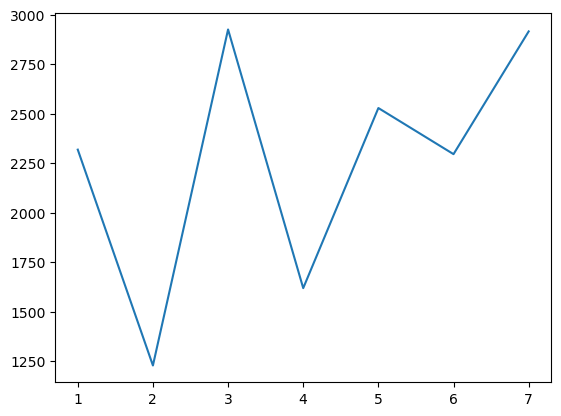

In [106]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [107]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_4 = keras.models.load_model('my_model')

#### Generación de secuencias

In [108]:
input_text='I wanna run away and open up my'

generate_seq(model_4, tok, input_text, max_length=max_context_size, n_words=1)

2024-08-07 22:35:45.874270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:46.163499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:46.175590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:46.348743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:46.360875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:46.546921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:46.558807: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 2s 2s/step


'I wanna run away and open up my lies'

####  Beam search y muestreo aleatorio

In [109]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model_4,num_beams=5,num_words=2,input="I wanna run away and open up",temp=1,mode='sto') #mode=sto es estocásitco, son muestreos aleatorios, pero puede ser determinista

2024-08-07 22:35:47.728724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:47.989043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:48.001003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:48.176760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:48.188702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:48.364454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:48.376638: I tensorflow/core/grappler/optimizers/cust

In [110]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(5, 11)

In [111]:
# veamos las salidas
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

['i wanna run away and open up to tried']
['i wanna run away and open up to flag']
['i wanna run away and open up it but']
["i wanna run away and open up me you're"]
['i wanna run away and open up to back']


Se ve que el modelo 4 tiene una mala predicción, no acertando en el generador de secuencias ni con beam search, aunque la perplexity y el train loss son menores. Se necesitan más documentos y se podrían hacer cambios en arquitectura para mejorar el desempeño.

### Modelo 5 - GRU (5 capas, Embedding dim=100)

In [112]:
from tensorflow.keras.layers import GRU
# Hay que probar cambiando las capas
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar. Se le puede dar un embedding ya entrenado. 
# input_shape: está en None pero podríamos poner 20, entran 20 tokens.
# output_dim: es el tamaño del embedding
model.add(Embedding(input_dim=vocab_size+1, output_dim=100, input_shape=(None,)))

# Esta capa recibe una secuencia de vectores
model.add(GRU(150, return_sequences=True))
# model.add(Dropout(0.2))

# Se stakean 2 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(GRU(150, return_sequences=True)) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))

# Se stakean 2 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(GRU(150, return_sequences=True)) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))

# Se stakean 2 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(GRU(150, return_sequences=True)) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))

# Se stakean 2 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(GRU(150, return_sequences=True)) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
# +1 debido a palabras nuevas que pudo no haber aprendido
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE,
# que en ese caso sería solo CategoricalCrossentropy().
# En el fondo es un problema de clasificación.
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
#model.compile(
#    loss=SparseCategoricalCrossentropy(),
#    optimizer=Adam(),  # Cambia 'rmsprop' por Adam
#    metrics=['accuracy']  # Puedes agregar métricas adicionales si es necesario
#)
model.summary()

# La salida es del tamaño del vocabulario

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 100)         237700    
                                                                 
 gru (GRU)                   (None, None, 150)         113400    
                                                                 
 gru_1 (GRU)                 (None, None, 150)         135900    
                                                                 
 gru_2 (GRU)                 (None, None, 150)         135900    
                                                                 
 gru_3 (GRU)                 (None, None, 150)         135900    
                                                                 
 gru_4 (GRU)                 (None, None, 150)         135900    
                                                                 
 dense_8 (Dense)             (None, None, 2377)       

In [113]:
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences

class PplCallback(Callback):
    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
        super(PplCallback, self).__init__()
        # El callback lo inicializamos con secuencias de validación sobre las cuales
        # mediremos la perplejidad y la paciencia para detener el entrenamiento.
        self.val_data = val_data
        self.history_ppl = history_ppl
        self.patience = patience
        self.patience_counter = 0
        self.min_score = np.inf

        self.target = []
        self.padded = []
        count = 0
        self.info = []

        # Nos movemos en todas las secuencias de los datos de validación
        for seq in self.val_data:
            len_seq = len(seq)
            # Armamos todas las subsecuencias
            subseq = [seq[:i] for i in range(len_seq)]
            self.target.extend([seq[i] for i in range(len_seq)])

            if len(subseq) != 0:
                self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))
                self.info.append((count, count + len_seq))
                count += len_seq

        self.padded = np.vstack(self.padded)

    # Se va a ejecutar cuando termine una época, calculando la perplejidad y si empeora lo interrumpe
    def on_epoch_end(self, epoch, logs=None):
        # En `scores` iremos guardando la perplejidad de cada secuencia
        scores = []
        predictions = self.model.predict(self.padded, verbose=0)

        # Para cada secuencia de validación
        for start, end in self.info:
            # En `probs` iremos guardando las probabilidades de los términos target
            probs = [predictions[idx_seq, -1, idx_vocab] for idx_seq, idx_vocab in zip(range(start, end), self.target[start:end])]
            # Calculamos la perplejidad por medio de logaritmos
            scores.append(np.exp(-np.sum(np.log(probs)) / (end - start)))

        # Promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # Chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
            self.min_score = current_score
            self.model.save("my_model")
            print("Saved new model!")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter == self.patience:
                print("Stopping training...")
                self.model.stop_training = True


In [114]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=32)
# Hay que seleccionar un Corpus más sustancioso para entrenar el modelo de lenguaje.

Epoch 1/20


2024-08-07 22:35:51.480841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:52.096694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:52.251785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:52.378191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:52.508843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:52.634054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:35:52.942731: I tensorflow/core/grappler/optimizers/cust

854/854 [==============================] - ETA: 0s - loss: 3.2692

2024-08-07 22:36:37.367273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:36:37.529446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:36:37.643904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:36:37.758255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:36:37.872741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:36:37.991273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



 mean perplexity: 3118.447124231539 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
854/854 [==============================] - 56s 60ms/step - loss: 3.2692
Epoch 2/20
854/854 [==============================] - ETA: 0s - loss: 2.8084
 mean perplexity: 1901.2166317710612 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
854/854 [==============================] - 42s 50ms/step - loss: 2.8084
Epoch 3/20
854/854 [==============================] - ETA: 0s - loss: 2.6012
 mean perplexity: 1235.485624856185 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
854/854 [==============================] - 43s 50ms/step - loss: 2.6012
Epoch 4/20
854/854 [==============================] - ETA: 0s - loss: 2.4244
 mean perplexity: 1988.8891067476634 

854/854 [==============================] - 38s 44ms/step - loss: 2.4244
Epoch 5/20
854/854 [==============================] - ETA: 0s - loss: 2.2690
 mean perplexity: 1521.0794592384332 

854/854 [==============================] - 37s 44ms/step - loss: 2.2690
Epoch 6/20
854/854 [==============================] - ETA: 0s - loss: 2.1327
 mean perplexity: 1380.0682601151912 

854/854 [==============================] - 37s 44ms/step - loss: 2.1327
Epoch 7/20
854/854 [==============================] - ETA: 0s - loss: 2.0183
 mean perplexity: 2618.5771378286004 

854/854 [==============================] - 37s 43ms/step - loss: 2.0183
Epoch 8/20
854/854 [==============================] - ETA: 0s - loss: 1.9195
 mean perplexity: 2966.4283522480378 

Stopping training...
854/854 [=============

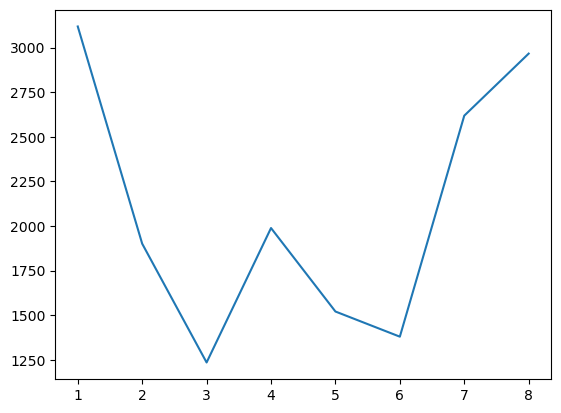

In [115]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [116]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_5 = keras.models.load_model('my_model')

#### Generación de secuencias

In [117]:
input_text='I wanna run away and open up my'

generate_seq(model_5, tok, input_text, max_length=max_context_size, n_words=1)

2024-08-07 22:41:20.448206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:20.611713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:20.897316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:20.996359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:21.094432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-08-07 22:41:21.193678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


'I wanna run away and open up my lies'

####  Beam search y muestreo aleatorio

In [118]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model_5,num_beams=5,num_words=2,input="I wanna run away and open up",temp=1,mode='sto') #mode=sto es estocásitco, son muestreos aleatorios, pero puede ser determinista

2024-08-07 22:41:21.760777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:21.922658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:22.022719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:22.119135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:22.219395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:22.316815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [119]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(5, 11)

In [120]:
# veamos las salidas
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

['i wanna run away and open up your lies']
['i wanna run away and open up your same']
['i wanna run away and open up your day']
['i wanna run away and open up your act']
['i wanna run away and open up your bringing']


Se ve que el modelo 5 tiene una mala predicción, no acertando en el generador de secuencias ni con beam search. Se necesitan más documentos y cambios en la arquitectura.

### Modelo 6 - GRU Bidirectional (3 capas, Embedding dim = 150, GRU dim = 300, optimizer lr = 0.0001)

In [121]:
from tensorflow.keras.optimizers import RMSprop
# Hay que probar cambiando las capas
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar. Se le puede dar un embedding ya entrenado. 
# input_shape: está en None pero podríamos poner 20, entran 20 tokens.
# output_dim: es el tamaño del embedding
model.add(Embedding(input_dim=vocab_size+1, output_dim=150, input_shape=(None,)))

# Esta capa recibe una secuencia de vectores
model.add(Bidirectional(GRU(300, return_sequences=True)))
#model.add(Dropout(0.3))

# Se stakean 2 a cada paso de tiempo la capa que le sigue debe recibir la salida parcial
model.add(Bidirectional(GRU(300, return_sequences=True))) # Como es many to many también debe tener return_sequences=True. 
# model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.3))

model.add(Bidirectional(GRU(300, return_sequences=True)))


# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
# +1 debido a palabras nuevas que pudo no haber aprendido
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE,
# que en ese caso sería solo CategoricalCrossentropy().
# En el fondo es un problema de clasificación.
model.compile(loss=SparseCategoricalCrossentropy(), optimizer=RMSprop(learning_rate=0.0001))
#model.compile(
#    loss=SparseCategoricalCrossentropy(),
#    optimizer=Adam(),  # Cambia 'rmsprop' por Adam
#    metrics=['accuracy']  # Puedes agregar métricas adicionales si es necesario
#)
model.summary()

# La salida es del tamaño del vocabulario

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 150)         356550    
                                                                 
 bidirectional_12 (Bidirect  (None, None, 600)         813600    
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, None, 600)         1623600   
 ional)                                                          
                                                                 
 bidirectional_14 (Bidirect  (None, None, 600)         1623600   
 ional)                                                          
                                                                 
 dense_9 (Dense)             (None, None, 2377)        1428577   
                                                      

In [122]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)
# Hay que seleccionar un Corpus más sustancioso para entrenar el modelo de lenguaje.

Epoch 1/20


2024-08-07 22:41:25.564608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:26.327047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:26.343022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:26.546864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:26.561967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:26.758768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:41:26.773472: I tensorflow/core/grappler/optimizers/cust

427/427 [==============================] - ETA: 0s - loss: 3.4717

2024-08-07 22:42:12.337412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:42:12.563717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:42:12.577172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:42:12.764014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:42:12.774741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:42:12.960089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:42:12.970479: I tensorflow/core/grappler/optimizers/cust


 mean perplexity: 12698.295116845595 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 64s 138ms/step - loss: 3.4717
Epoch 2/20
427/427 [==============================] - ETA: 0s - loss: 2.7846
 mean perplexity: 4486.030017122715 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 48s 113ms/step - loss: 2.7846
Epoch 3/20
427/427 [==============================] - ETA: 0s - loss: 2.3221
 mean perplexity: 6325.622159639693 

427/427 [==============================] - 38s 89ms/step - loss: 2.3221
Epoch 4/20
427/427 [==============================] - ETA: 0s - loss: 2.0470
 mean perplexity: 3927.693422612437 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 46s 108ms/step - loss: 2.0470
Epoch 5/20
427/427 [==============================] - ETA: 0s - loss: 1.8126
 mean perplexity: 4012.3311698489797 

427/427 [==============================] - 37s 86ms/step - loss: 1.8126
Epoch 6/20
427/427 [==============================] - ETA: 0s - loss: 1.5813
 mean perplexity: 2405.5865809467646 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 46s 108ms/step - loss: 1.5813
Epoch 7/20
427/427 [==============================] - ETA: 0s - loss: 1.3823
 mean perplexity: 2004.5923364467112 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 47s 111ms/step - loss: 1.3823
Epoch 8/20
427/427 [==============================] - ETA: 0s - loss: 1.2197
 mean perplexity: 1984.014311122411 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 47s 110ms/step - loss: 1.2197
Epoch 9/20
427/427 [==============================] - ETA: 0s - loss: 1.0873
 mean perplexity: 1548.047935364499 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 47s 110ms/step - loss: 1.0873
Epoch 10/20
427/427 [==============================] - ETA: 0s - loss: 0.9780
 mean perplexity: 1418.137041208329 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 47s 109ms/step - loss: 0.9780
Epoch 11/20
427/427 [==============================] - ETA: 0s - loss: 0.8898
 mean perplexity: 1217.3207963556981 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 47s 110ms/step - loss: 0.8898
Epoch 12/20
427/427 [==============================] - ETA: 0s - loss: 0.8167
 mean perplexity: 1446.5819125242413 

427/427 [==============================] - 37s 87ms/step - loss: 0.8167
Epoch 13/20
427/427 [==============================] - ETA: 0s - loss: 0.7552
 mean perplexity: 1130.0481601352503 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 45s 105ms/step - loss: 0.7552
Epoch 14/20
427/427 [==============================] - ETA: 0s - loss: 0.7032
 mean perplexity: 1023.0597418617065 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 47s 109ms/step - loss: 0.7032
Epoch 15/20
427/427 [==============================] - ETA: 0s - loss: 0.6599
 mean perplexity: 997.1848108732167 

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
427/427 [==============================] - 47s 109ms/step - loss: 0.6599
Epoch 16/20
427/427 [==============================] - ETA: 0s - loss: 0.6220
 mean perplexity: 1047.2089986411852 

427/427 [==============================] - 38s 89ms/step - loss: 0.6220
Epoch 17/20
427/427 [==============================] - ETA: 0s - loss: 0.5892
 mean perplexity: 1226.542352847937 

427/427 [==============================] - 35s 82ms/step - loss: 0.5892
Epoch 18/20
427/427 [==============================] - ETA: 0s - loss: 0.5595
 mean perplexity: 1185.356078896934 

427/427 [==============================] - 35s 83ms/step - loss: 0.5595
Epoch 19/20
427/427 [==============================] - ETA: 0s - loss: 0.5319
 mean perplexity: 1444.3329735246996 

427/427 [==============================] - 35s 83ms/step - loss: 0.5319
Epoch 20/20
427/427 [==============================] - ETA: 0s - loss: 0.5071
 mean perplexity: 1181.4122849721657 

Stopping training...
427/427 [=========

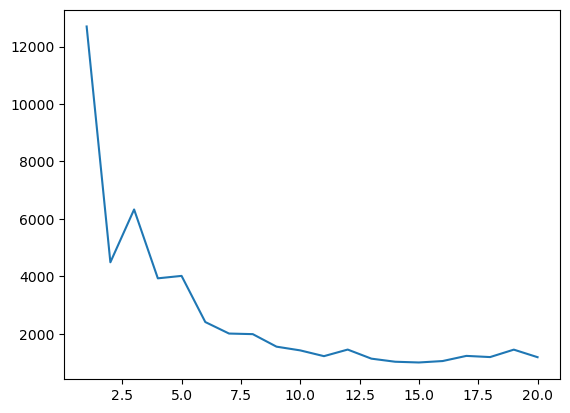

In [123]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [124]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_6 = keras.models.load_model('my_model')

#### Generación de secuencias

In [125]:
input_text='I wanna run away and open up my'

generate_seq(model_6, tok, input_text, max_length=max_context_size, n_words=1)

2024-08-07 22:55:59.349320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:55:59.552740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:55:59.563333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:55:59.921020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:55:59.931739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:56:00.133371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:56:00.143901: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 2s 2s/step


'I wanna run away and open up my mind'

####  Beam search y muestreo aleatorio

In [126]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model_6,num_beams=5,num_words=2,input="I wanna run away and open up",temp=1,mode='sto') #mode=sto es estocásitco, son muestreos aleatorios, pero puede ser determinista

2024-08-07 22:56:00.933001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:56:01.133431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:56:01.144441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:56:01.299199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:56:01.309639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:56:01.462849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-07 22:56:01.473372: I tensorflow/core/grappler/optimizers/cust

In [127]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(5, 11)

In [128]:
# veamos las salidas
for i in range(salidas.shape[0]):
    print(decode(salidas[i]))

['i wanna run away and open up to come']
['i wanna run away and open up to just']
['i wanna run away and open up in flames']
['i wanna run away and open up to all']
["i wanna run away and open up to runnin'"]


Se ve que el modelo 6 tiene una muy buena predicción, acertando en el generador de secuencias.

Se pudieron observar los resultados de train loss y perplexity probando diferentes arquitecturas e hiperparámetros. Entre los modelos se destacaron aquellos bidireccionales. Se necesitan más documentos para poder mejorar las métricas y realizar cambios en algunas arquitecturas.